In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import utils as nn_utils
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# torch.manual_seed(0)
# np.random.seed(0)

In [36]:
def generate_line(n, sign = "+"):
    t = torch.linspace(-3, 3, n)
    x = t.view(-1, 1)
    if sign == "+":
        y = t.view(-1, 1)
    else:
        y = -t.view(-1, 1)
    return torch.cat((x, y), dim=1).unsqueeze(0)


def generate_line_small(n, sign = "+"):
    t = torch.linspace(-1, 1, n)
    x = t.view(-1, 1)
    if sign == "+":
        y = t.view(-1, 1)
    else:
        y = -t.view(-1, 1)
    return torch.cat((x, y), dim=1).unsqueeze(0)

def generate_parabola(n, sign = "+"):
    t = torch.linspace(-10, 10, n)
    x = (t).view(-1, 1)
    if sign == "+":
        y =((t**2).view(-1, 1) + 5)/5
    else:
        y = (-(t**2).view(-1, 1) - 5)/5
    return torch.cat((x, y), dim=1).unsqueeze(0)

def generate_circle(n, r = 1):
    t = torch.linspace(0, 2 * torch.pi - 1e-3, n)
    x = (r * torch.cos(t)).view(-1, 1)
    y = (r * torch.sin(t)).view(-1, 1)
    return torch.cat((x, y), dim=1).unsqueeze(0)


def generate_sphere(n, a = 1, b = 1, c = 1):
    t1 = torch.linspace(0, 2*torch.pi - 1e-3, n)
    t2 = torch.linspace(0, torch.pi - 1e-3, n)
    grid_t1, grid_t2 = torch.meshgrid((t1, t2), indexing='ij')
    # t = torch.stack((grid_t1, grid_t2), dim=-1).reshape(-1, 2).to(device)
    x = (a * torch.sin(grid_t1) * torch.cos(grid_t2)).view(-1, 1)
    y = (b * torch.sin(grid_t1) *  torch.sin(grid_t2)).view(-1, 1)
    z = (c * torch.cos(grid_t1)).view(-1, 1)
    return torch.cat((x, y, z), dim=1).unsqueeze(0)

def generate_donut(n, a = 1, b = 1, c = 1):
    t1 = torch.linspace(0, 2*torch.pi - 1e-3, n)
    t2 = torch.linspace(0, 2*torch.pi - 1e-3, n)
    grid_t1, grid_t2 = torch.meshgrid((t1, t2), indexing='ij')
    # t = torch.stack((grid_t1, grid_t2), dim=-1).reshape(-1, 2).to(device)
    x = ((torch.sin(grid_t1) + 2) * torch.cos(grid_t2)).view(-1, 1)
    y = ((torch.sin(grid_t1) + 2) *  torch.sin(grid_t2)).view(-1, 1)
    z = 0.5*(torch.cos(grid_t1)).view(-1, 1)
    return torch.cat((x, y, z), dim=1).unsqueeze(0)

def generate_3D_ellipse(n, r1 = 1, r2 = 0.5):
    t = torch.linspace(0, 2 * torch.pi, n+1)
    x = (r1 * torch.cos(t)).view(-1, 1)[:-1]
    y = (r2 * torch.sin(t)).view(-1, 1)[:-1]
    z = (0 * torch.sin(t)).view(-1, 1)[:-1]
    return torch.cat((x, y, z), dim=1).unsqueeze(0)


def generate_ellipse(n, r1 = 1, r2 = 0.5):
    t = torch.linspace(0, 2*torch.pi, n+1)
    x = (r1 * torch.cos(t)).view(-1, 1)[:-1]
    y = (r2 * torch.sin(t)).view(-1, 1)[:-1]
    return torch.cat((x, y), dim=1).unsqueeze(0)

def generate_data(n, sign = "+"):
    line = generate_line(n, sign)
    line2 = generate_line_small(n, sign = '-')
    parabola = generate_parabola(n, sign)
    parabola1 = generate_parabola(n, sign = '-')
    circle = generate_circle(n)
    circle1 = generate_circle(n, r=2)
    e1 = generate_ellipse(n, r1 = 1.5, r2 = 3)
    e2 = generate_ellipse(n, r1 = 4, r2 = 2)
    curves =  generate_ellipse(n, r1 = 2.5, r2 = 2.5)
    for i in range(10,30):
        # for j in range(1,5):
        e1 = generate_ellipse(n, r1 = i/4, r2 = i/4)
        curves = torch.concat((curves, e1))
    return curves

def plot_data(data, mode = '3D'):
    data = data.to("cpu").detach().numpy()

    if mode == '3D':
        fig = plt.figure(figsize=(15, 5))  # Create a wide figure to accommodate three subplots

        # First subplot
        ax1 = fig.add_subplot(131, projection='3d')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        ax1.view_init(elev=20, azim=30)  # Set the viewing angle
        for i in range(data.shape[0]):
            ax1.scatter(data[i, :, 0], data[i, :, 1], data[i, :, 2], alpha=1.0, s=0.5)
        ax1.set_title('View 1')

        # Second subplot
        ax2 = fig.add_subplot(132, projection='3d')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')
        ax2.view_init(elev=40, azim=60)  # Change the viewing angle
        for i in range(data.shape[0]):
            ax2.scatter(data[i, :, 0], data[i, :, 1], data[i, :, 2], alpha=1.0, s=0.5)
        ax2.set_title('View 2')

        # Third subplot
        ax3 = fig.add_subplot(133, projection='3d')
        ax3.set_xlabel('X')
        ax3.set_ylabel('Y')
        ax3.set_zlabel('Z')
        ax3.view_init(elev=60, azim=90)  # Change the viewing angle again
        for i in range(data.shape[0]):
            ax3.scatter(data[i, :, 0], data[i, :, 1], data[i, :, 2], alpha=1.0, s=0.5)
        ax3.set_title('View 3')

        plt.tight_layout()
        plt.show()
    else:
        for i in range(data.shape[0]):
            plt.scatter(data[i, :, 0], data[i, :, 1], s=1.5)
        plt.show()

In [37]:
class H_theta(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(H_theta, self).__init__()
        # self.inp = nn.Linear(input_dim, 500)
        # self.relu = nn.ReLU()
        # self.out = nn.Linear(500, output_dim)
        # self.relu = nn.ReLU()
        # self.out = nn.Linear(500, output_dim)
        self.model = \
        nn.Sequential(
            nn.Linear(input_dim, 2000),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.ReLU(),
            # nn.Linear(25, 25),
            # nn.ReLU(),
            nn.Linear(2000, output_dim)
        )

    def forward(self, x, disp = False):
        # inp = self.inp(x)
        # relu = self.relu(inp)
        # out = self.out(relu)
        # if disp:
        #     with torch.no_grad():
        #         print("Layer 1: \n", torch.norm(inp, dim=2))
        #         print("Layer 2 (Hiddin Layer): \n", torch.norm(relu, dim=2))
        #         print("Layer Out: \n", torch.norm(out, dim = 2))
        out = self.model(x)
        return out
    
class H_theta_new(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(H_theta_new, self).__init__()
        # self.inp = nn.Linear(input_dim, 500)
        # self.relu = nn.ReLU()
        # self.out = nn.Linear(500, output_dim)
        # self.relu = nn.ReLU()
        # self.out = nn.Linear(500, output_dim)
        self.model = \
        nn.Sequential(
            nn.Linear(30, 2000),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.ReLU(),
            nn.Linear(2000, output_dim)
        )

        self.inject = \
        nn.Sequential(
            nn.Linear(input_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 2)
        )
        
        self.model1 = \
        nn.Sequential(
            nn.Linear(output_dim, 2000),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.ReLU(),
            nn.Linear(2000, output_dim)
        )

    def forward(self, x, disp = False):
        # print("input shape:", x.shape) #100, 20, 2
        sc = self.inject(x)
        # print("injection shape", sc.shape) #100, 20, 2
        s = sc[:,:, 0].unsqueeze(-1)
        s = torch.max(torch.tensor(0.), 1 + s)
        c = sc[:,:, 1].unsqueeze(-1)
        # print("s shape", s.shape)
        # print("c shape", c.shape)
        y = self.model(torch.ones((s.shape[0], s.shape[1], 30), device=device))
        # print("y shape", y.shape)
        y = nn.LayerNorm(normalized_shape=2, device=device)(y)
        x = (s*y + c).to(device)
        x = self.model1(x).to(device)
        # print("Out shape", x.shape)
        return x


def generate_NN_latent_functions(num_samples, xdim=1, zdim=2, bias=0):
    class NN(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(NN, self).__init__()
            self.fc1 = nn.Linear(input_dim, 500)
            #self.fc2 = nn.Linear(100, 100)
            self.fc3 = nn.Linear(500, 500)
            self.fc4 = nn.Linear(500, output_dim)

            for param in self.parameters():
                param.requires_grad = False

        def forward(self, x):
            with torch.no_grad():
                x = torch.relu(self.fc1(x))
                #x = torch.relu(self.fc2(x))
                x = torch.relu(self.fc3(x))
                x = self.fc4(x)
            return x

    #  weight initialization function
    def weights_init_normal(m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0, std=1)
            #nn.init.xavier_normal_(m.weight, gain = 0.5)
            if m.bias is not None:
                nn.init.constant_(m.bias, val=bias)

    #  neural networks
    networks = []
    for _ in range(num_samples):
        net = NN(xdim, zdim)
        net.apply(weights_init_normal)
        networks.append(net)

    return networks



In [38]:
def find_nns(Y, G, disp = False):
    #Y: [1, 1024, 3]
    #G: [20, 1024, 3]

    distances = torch.sum(((Y - G) ** 2), dim = 2).mean(dim = 1)
    min_, min_idx = torch.min(distances, dim=0)
    return min_idx.item()

def diffs(Y, G):
    weighted_diffs = (G - Y)**2

    diffs = torch.sum(weighted_diffs, dim=2)
    return diffs

def f_loss(Y, G):
    diff = diffs(Y,G)
    point_loss_mean = diff.mean(dim=1)
    curve_loss_mean = point_loss_mean.mean(dim=0)
    return curve_loss_mean



def pos_encoder(x, L):

    _, n = x.shape

    encoding = []

    for i in range(n):
        for l in range(L):
            encoding.append(torch.sin(1.1*(2**l) * torch.pi * x[:, i:i+1]))
            encoding.append(torch.cos(1.1*(2**l) * torch.pi * x[:, i:i+1]))
            # print('L:', l)
            # print('x:',x[:, i:i+1])
            # print('Trig_in: ', 1.1*(2**l) * x[:, i:i+1])
            # print("Sin:")
            # print(torch.sin(1.1*(2**l) * torch.pi * x[:, i:i+1]))
            # print("Cos:")
            # print(torch.cos(1.1*(2**l) * torch.pi * x[:, i:i+1]))
            # print()
    encoded_x = torch.cat(encoding, dim=-1)*5

    return encoded_x


x = torch.randn(2, 1)  # Example tensor with 10 points in 2D
x = torch.Tensor([[-2],[2]])

encoded_x = pos_encoder(x, L=3)
#print(encoded_t)  # Should print torch.Size([10, 8])
Zs = generate_NN_latent_functions(num_samples=3, xdim=6, zdim=4, bias=1)

Z = (Zs[0](encoded_x))

# print("Z shape: ", Z.shape)
# print("encoded_x shape: ", encoded_x.shape)
# print()
# for i, model in enumerate(Zs):
#     model = model
#     #Zxs[i] = torch.cat((model(z_in), x), dim=1).to(device)
#     Z = (model(encoded_x))
#     print('Positional Encoding for x = -1:' )
#     print(encoded_x[0])
#     print("Output of Z_"+str(i)+" for x = -1:")
#     print(Z[0])
#     print()
#     print('Positional Encoding for x = 1:' )
#     print(encoded_x[1])
#     print("Output of Z_"+str(i)+" for x = 1:")
#     print(Z[1])
#     print('-------------------------------------------------------------------------------')





# tensor1 = torch.randn(1, 1024, 3)
# tensor2 = torch.randn(20, 1024, 3)
# find_nns(tensor1, tensor2)


# encoding.append(torch.sin(1.5*(2**l) * torch.pi * x[:, i:i+1]))
# encoding.append(torch.cos(1.5*(2**l) * torch.pi * x[:, i:i+1]))

In [39]:
!del /Q /F "plots/*"

The system cannot find the path specified.


In [40]:
epochs = 2500
staleness = 2
num_Z_samples = 100
lr = 0.0005
num_points = 20
xdim = 1
zdim = 30         # lower and higher both not good, especially lower
pos_enc_L = 6       # 7 does not converge, 5 and 8 worse than 6
output_dim = 2
plot_epoch = 500
b1 = 0.85      # increasing and decreasing by 0.01 both worse
b2 = 0.999
gamma = 0.95
step = 70
z_scale = 100         # lower does not converge, higher is slower


In [41]:
if xdim == 1:
    x = torch.linspace(-0.05, 0.05, num_points).to(device).unsqueeze(1)
else:
    x1 = torch.linspace(1.0, 2, 40)
    x2 = torch.linspace(1.0, 2, 40)
    grid_x1, grid_x2 = torch.meshgrid((x1, x2), indexing='ij')
    x = torch.stack((grid_x1, grid_x2), dim=-1).reshape(-1, 2).to(device)
data = (generate_data(num_points)).to(device)
print(data.shape)

torch.Size([21, 20, 2])


  0%|          | 0/2500 [00:00<?, ?it/s]

tensor(23.8827, device='cuda:0', grad_fn=<MeanBackward1>)


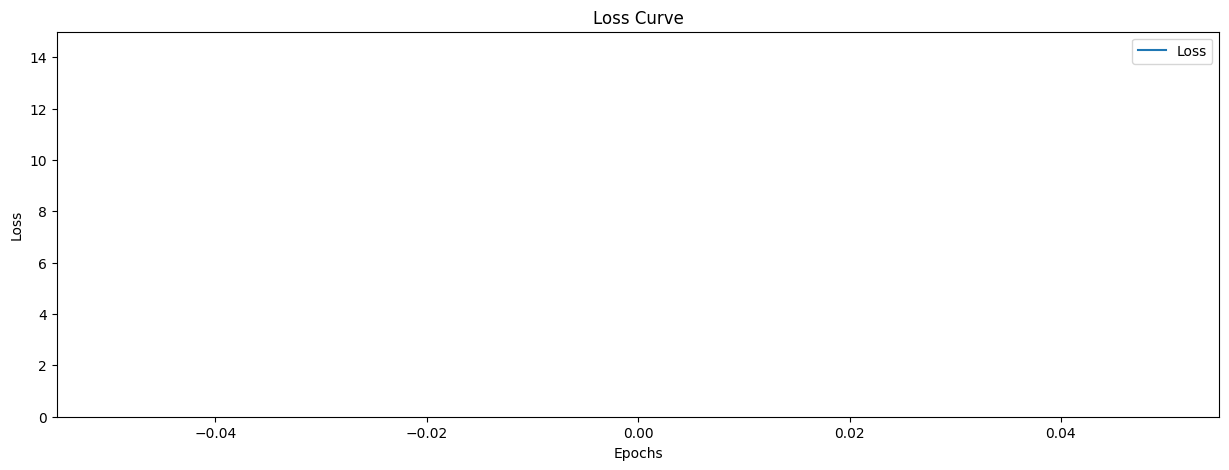

 20%|█▉        | 499/2500 [01:21<05:30,  6.06it/s]

tensor(22.0983, device='cuda:0', grad_fn=<MeanBackward1>)


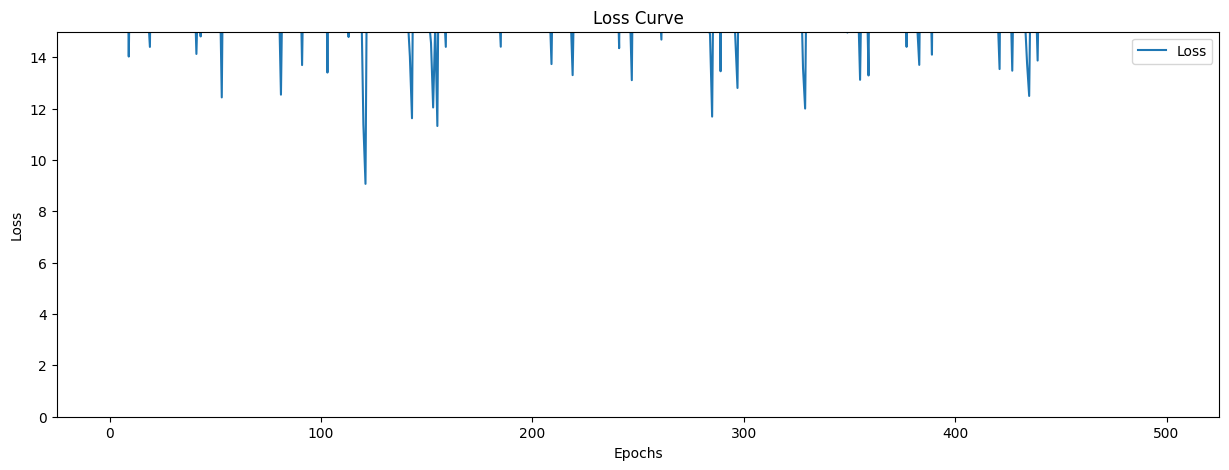

 22%|██▏       | 561/2500 [01:32<05:35,  5.78it/s]

In [ ]:
id += 1
param_name = str(id)
torch.manual_seed(1)
np.random.seed(1)
# Initialize the model and optimizer
H_t = H_theta(input_dim=zdim, output_dim=output_dim).to(device)
#optimizer = optim.Adam(H_t.parameters(), lr=lr, eps=5e-1)
optimizer = optim.AdamW(H_t.parameters(), lr=lr, betas=(b1, b2), eps = 1e-8)
#optimizer = optim.SGD(H_t.parameters(), lr=lr, momentum=0.95)

scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=gamma, step_size= step)

os.makedirs('notebook_plots/'+param_name, exist_ok=True)

# Initialize lists to store gradient and parameter norms
grad_norms = []
param_norms = []
losses = []
Zxs = torch.empty((num_Z_samples, num_points, zdim)).to(device)
z_in = pos_encoder(x, L=pos_enc_L)
for e in tqdm(range(epochs)):
    # Check if we need to update the stored model parameters
    if e % staleness == 0:
        Zs = generate_NN_latent_functions(num_samples=num_Z_samples, xdim=z_in.shape[1], zdim=zdim, bias=1)
        for i, model in enumerate(Zs):
            model = model.to(device)
            Zxs[i] = (model(z_in)/z_scale).to(device)
        generated = H_t(Zxs).to(device)

        imle_nns = [find_nns(d, generated) for d in data]
        imle_transformed_points = torch.empty((data.shape[0], num_points, zdim)).to(device)
        # for i, index in enumerate(imle_nns):
        #     imle_transformed_points[i] = Zxs[index]
        perturbed_Zs = []
        for i, idx in enumerate(imle_nns):
            model = Zs[idx]
            perturbed_model = copy.deepcopy(model)
            with torch.no_grad():
                for param in perturbed_model.parameters():
                    param.add_(torch.randn_like(param) * 0.2)
            perturbed_Zs.append(perturbed_model)
            perturbed_model = perturbed_model.to(device)
            imle_transformed_points[i] = (perturbed_model(z_in) / z_scale).to(device)

    # Zero gradients, calculate loss, backpropagate, and update weights
    optimizer.zero_grad()
    outs = H_t(imle_transformed_points)
    loss = f_loss(data, outs)
    losses.append(loss.item())

    # Visualize generated points and save plots
    #if e < 900 and e >= 800:
    if e%plot_epoch == 0 or e == epochs - 1:
        generated_disp = generated.to(device='cpu').detach().numpy()
        outs_disp = outs.to(device='cpu').detach().numpy()
        points_disp = data.to(device='cpu').detach().numpy()
        plt.figure(figsize=(15, 15))
        for i in range(data.shape[0]):
            line1 = plt.plot(outs_disp[i, :, 0], outs_disp[i, :, 1], marker='+')
            color = line1[0].get_color()
            plt.plot(points_disp[i, :, 0], points_disp[i, :, 1], marker='o', color=color)

        #print(f'Epoch {str(e)}/{epochs}', str(loss.item()))

        #plt.show()
        #Save the figutes
        
        plt.title(f'Epoch: {e}')
        plt.savefig(f"notebook_plots/{param_name}/epoch_{e}.png")
        #Close plts
        plt.close()
        print(loss)
        plt.figure(figsize=(15, 5))
        plt.plot(losses, label='Loss')
        plt.ylim(0, 15)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()
        plt.show()



    loss.backward()

    # nn_utils.clip_grad_norm_(H_t.parameters(), max_norm=17.5)
    # if e >= 75:
    #     nn_utils.clip_grad_norm_(H_t.parameters(), max_norm=5)
    # else:
    #nn_utils.clip_grad_norm_(H_t.parameters(), max_norm=40)
    # Calculate and store the norms of parameters and gradients
    grad_sum = 0
    param_sum = 0
    for param in H_t.parameters():
        param_sum += torch.norm(param)**2
        grad_sum += torch.norm(param.grad)**2


    # if e >= 570 and e <600:
    #     print("68th Epoch Paramters")
    #     print(f"Loss: {losses[67]}")
    #     print(f"Diffs", diffs(data, outs))
    #     H_t(imle_transformed_points, disp = True)


    # if e == 67:
    #     print("68th Epoch Paramters")
    #     print(f"Loss: {losses[67]}")
    #     print(f"Diffs", diffs(data, outs))
    #     H_t(imle_transformed_points, disp = True)
    #     for param in H_t.parameters():
    #         print(param.grad.shape)
    # if e == 68:
    #     print("69th Epoch Paramters")
    #     print(f"Loss: {losses[68]}")
    #     print(f"Diffs", diffs(data, outs))
    #     H_t(imle_transformed_points, disp = True)
    #     # for param in H_t.parameters():
    #     #     print(param)
    # if e == 69:
    #     print("70th Epoch Paramters")
    #     print(f"Loss: {losses[69]}")
    #     print(f"Diffs", diffs(data, outs))
    #     H_t(imle_transformed_points, disp = True)


    # if e == 74:
    #     print("75th Epoch Paramters")
    #     print(f"Loss: {losses[74]}")
    #     print(f"Diffs", diffs(data, outs))
    #     H_t(imle_transformed_points, disp = True)
    #     # for param in H_t.parameters():
    #     #     print(param)


    grad_norm = torch.sqrt(grad_sum).item()
    param_norm = torch.sqrt(param_sum).item()
    grad_norms.append(grad_norm)
    param_norms.append(param_norm)

    # print("Gradient Norm:", grad_norm)
    # print("Parameter Norm:", param_norm)

    optimizer.step()
    #scheduler.step()

# print(f"25 Epochs: {losses[24]}")
# print(f"50 Epochs: {losses[49]}")
# print(f"100 Epochs: {losses[99]}")
# print(f"150 Epochs: {losses[149]}")
# print(f"200 Epochs: {losses[199]}")

# Plot the loss curve on a separate figure
plt.figure(figsize=(15, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig(f'notebook_plots/{param_name}/Loss Curve.png')
#plt.xticks(np.arange(0, 75), 1)
plt.show()

# Plot gradient norms and parameter norms with dual y-axes

#fig, ax1 = plt.subplots(figsize=(15, 5))
# Plot gradient norms on the primary y-axis
# ax1.plot(grad_norms, color='blue', label="Gradient Norms")
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Gradient Norms', color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')
# ax1.set_xticks(np.arange(0, len(grad_norms), 25))
# # Create a secondary y-axis for parameter norms
# ax2 = ax1.twinx()
# ax2.plot(param_norms, color='red', label="Parameter Norms")
# ax2.set_ylabel('Parameter Norms', color='red')
# ax2.tick_params(axis='y', labelcolor='red')

# # Title and layout adjustments
# plt.title('Gradient and Parameter Norms over Epochs')

# ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
# fig.tight_layout()
# plt.savefig(f'plots/{param_name}/ParamNorm vs GradNorm vs Epochs.png')
# plt.show()



# plt.figure(figsize=(20, 20))
# plt.plot(grad_norms, param_norms, marker='o')
# plt.xlabel('Gradient Norms')
# plt.ylabel('Parameter Norms')

# plt.title('Parameter Norms vs. Gradient Norms')
# plt.grid(True)
# for i, (grad, param) in enumerate(zip(grad_norms, param_norms)):
#     plt.text(grad, param, str(i), fontsize=8, ha='right', va='bottom')
# plt.savefig(f'plots/{param_name}/ParamNorm vs GradNorm.png')
# plt.show()

In [34]:
s = s = 5
print(s)

5


In [35]:
print(losses[-1])

18.575651168823242


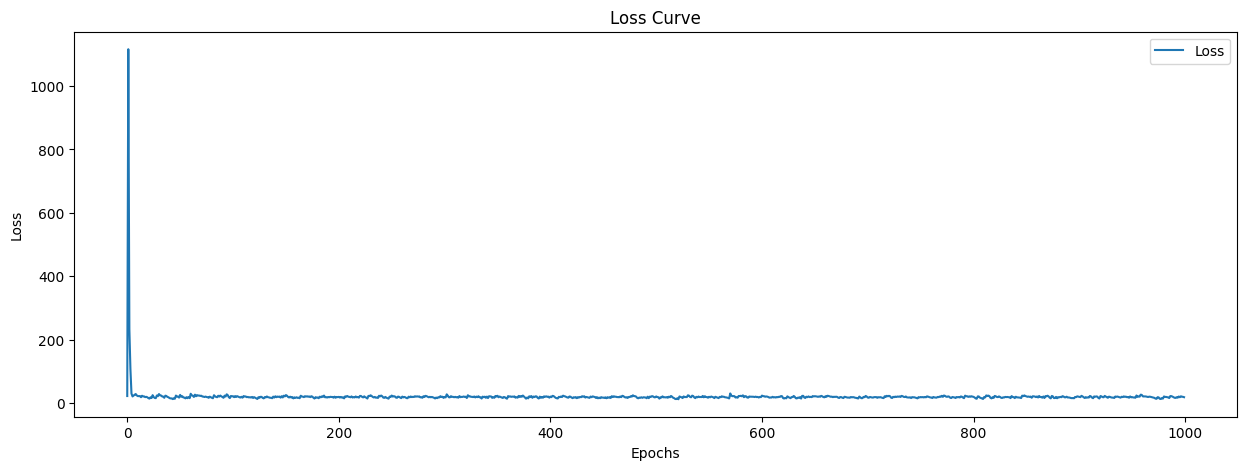

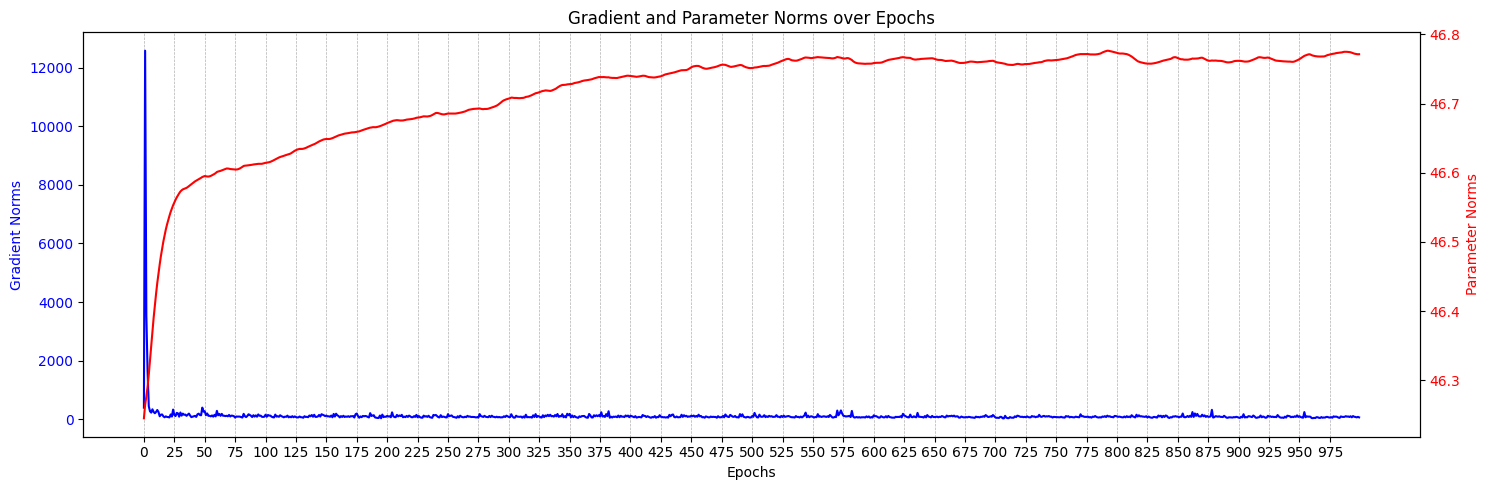

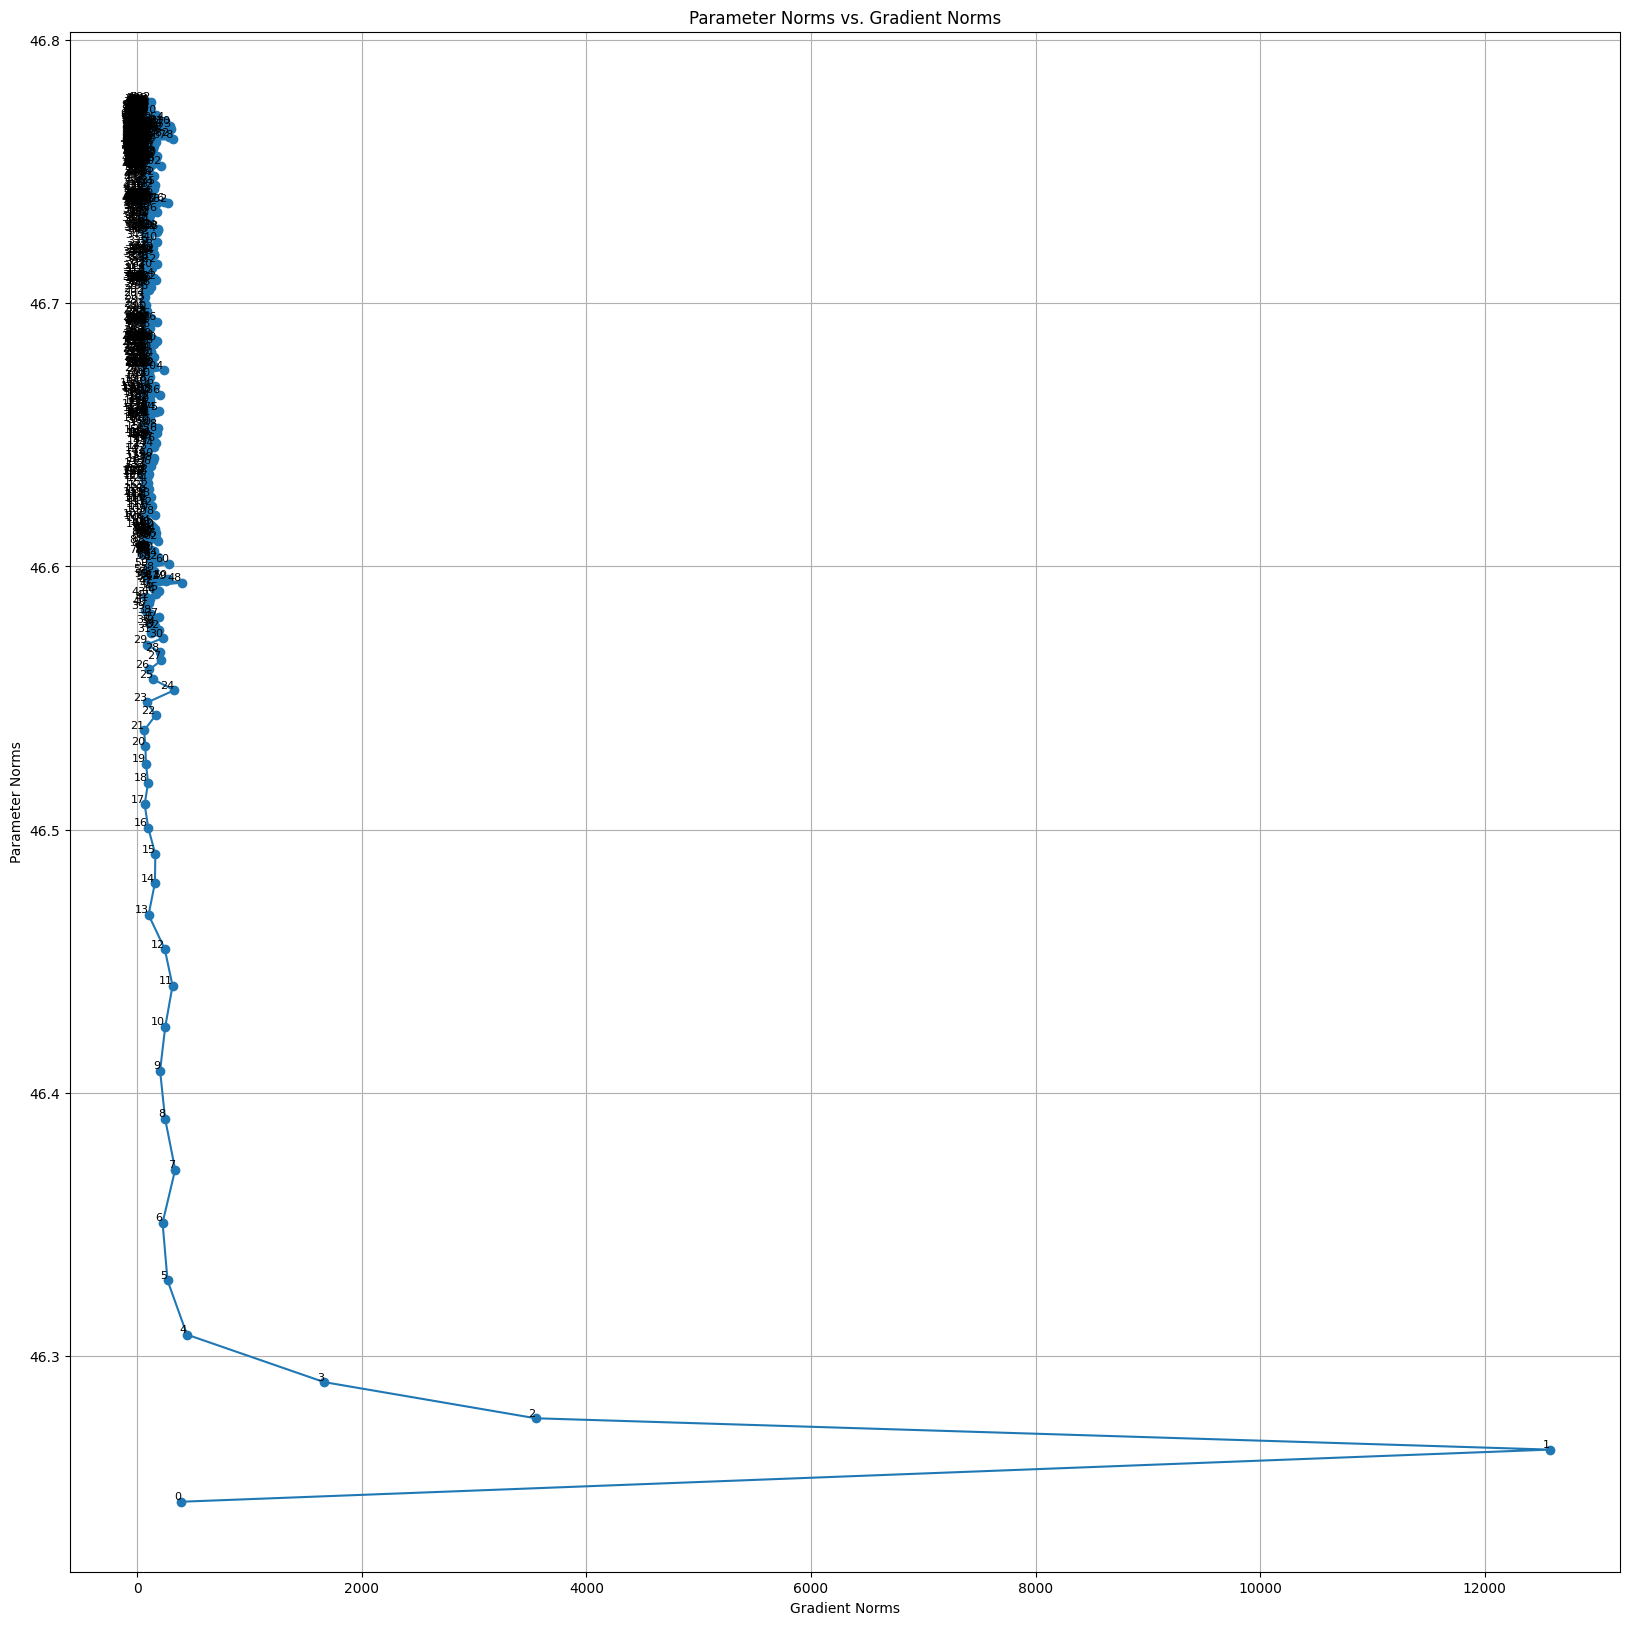

In [36]:
plt.figure(figsize=(15, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig(f'plots/{param_name}/Loss Curve.png')
#plt.xticks(np.arange(0, 75), 1)
plt.show()

# Plot gradient norms and parameter norms with dual y-axes

fig, ax1 = plt.subplots(figsize=(15, 5))
# Plot gradient norms on the primary y-axis
ax1.plot(grad_norms, color='blue', label="Gradient Norms")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Gradient Norms', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(np.arange(0, len(grad_norms), 25))
# Create a secondary y-axis for parameter norms
ax2 = ax1.twinx()
ax2.plot(param_norms, color='red', label="Parameter Norms")
ax2.set_ylabel('Parameter Norms', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and layout adjustments
plt.title('Gradient and Parameter Norms over Epochs')

ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
fig.tight_layout()
plt.savefig(f'plots/{param_name}/ParamNorm vs GradNorm vs Epochs.png')
plt.show()



plt.figure(figsize=(20, 20))
plt.plot(grad_norms, param_norms, marker='o')
plt.xlabel('Gradient Norms')
plt.ylabel('Parameter Norms')

plt.title('Parameter Norms vs. Gradient Norms')
plt.grid(True)
for i, (grad, param) in enumerate(zip(grad_norms, param_norms)):
    plt.text(grad, param, str(i), fontsize=8, ha='right', va='bottom')
plt.savefig(f'plots/{param_name}/ParamNorm vs GradNorm.png')
plt.show()